In [1]:
import numpy as np
import math,struct,pickle
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import copy

In [2]:
# 定义激活函数和激活函数的导数
def bypass(x):
    return x
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp=np.exp(x-x.max())
    return exp/exp.sum()

def d_softmax(data):
    sm=softmax(data)
    return np.diag(sm)-np.outer(sm,sm)

# def d_tanh(data):
#     return np.diag(1/(np.cosh(data))**2)
def d_tanh(data):
    return 1/(np.cosh(data))**2
def d_bypass(x):
    return 1

differential={softmax:d_softmax,tanh:d_tanh,bypass:d_bypass}
d_type={bypass:'times',softmax:'dot',tanh:'times'}

In [3]:
# 定义参数的初始值
dimensions=[28*28,100,10]
activation=[bypass,tanh,softmax]
distribution=[
    {}, # leave it empty!!
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])),math.sqrt(6/(dimensions[0]+dimensions[1]))]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[1]+dimensions[2])),math.sqrt(6/(dimensions[1]+dimensions[2]))]},
]

In [4]:
# 对参数进行初始化
def init_parameters_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [5]:
# 搭建神经网络，返回输出值
def predict(img,parameters):
    l_in=img
    l_out=activation[0](l_in)
    for layer in range(1,len(dimensions)):
        l_in=np.dot(l_out,parameters[layer]['w'])+parameters[layer]['b']
        l_out=activation[layer](l_in)
    return l_out

In [6]:
# 设置数据集路径
dataset_path=Path('./data')
train_img_path=dataset_path/'train-images.idx3-ubyte'
train_lab_path=dataset_path/'train-labels.idx1-ubyte'
test_img_path=dataset_path/'t10k-images.idx3-ubyte'
test_lab_path=dataset_path/'t10k-labels.idx1-ubyte'

In [7]:
# 导入数据集，其中验证集是从60000个训练集中分出的10000个
train_num=50000
valid_num=10000
test_num=10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255
    train_img=tmp_img[:train_num]
    valid_img=tmp_img[train_num:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255

with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab=np.fromfile(f,dtype=np.uint8)
    train_lab=tmp_lab[:train_num]
    valid_lab=tmp_lab[train_num:]
    
with open(test_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_lab=np.fromfile(f,dtype=np.uint8)

In [8]:
# 数据集的可视化
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(train_lab[index]))
def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(valid_lab[index]))
def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(test_lab[index]))

In [14]:
# 定义Loss函数L=(y-y_pred)^2
onehot=np.identity(dimensions[-1]) # onehot指定dimensions最后一个数为1，其他都为0

def sqr_loss(img,lab,parameters):
    y_pred=predict(img,parameters)
    y=onehot[lab] # 让lab为1，如：图片lab为5，让第5个为1，其他为0
    diff=y-y_pred
    return np.dot(diff,diff)

In [15]:
# 对参数求梯度
def grad_parameters(img,lab,parameters):
    l_in_list=[img]
    l_out_list=[activation[0](l_in_list[0])]
    for layer in range(1,len(dimensions)):
        l_in=np.dot(l_out_list[layer-1],parameters[layer]['w'])+parameters[layer]['b']
        l_out=activation[layer](l_in)
        l_in_list.append(l_in)
        l_out_list.append(l_out)
    
    d_layer=-2*(onehot[lab]-l_out_list[-1])
    
    grad_result=[None]*len(dimensions)
    for layer in range(len(dimensions)-1,0,-1):
        if d_type[activation[layer]]=='times':
            d_layer=differential[activation[layer]](l_in_list[layer])*d_layer
        if d_type[activation[layer]]=='dot':
            d_layer=np.dot(differential[activation[layer]](l_in_list[layer]),d_layer)
        grad_result[layer]={}
        grad_result[layer]['b']=d_layer
        grad_result[layer]['w']=np.outer(l_out_list[layer-1],d_layer)
        d_layer=np.dot(parameters[layer]['w'],d_layer)
    
    return grad_result

In [9]:
# 检测模型的准确度
def valid_loss(parameters):
    loss_accu=0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(valid_img[img_i],valid_lab[img_i],parameters)
    return loss_accu/(valid_num/10000)
def valid_accuracy(parameters):
    correct=[predict(valid_img[img_i],parameters).argmax()==valid_lab[img_i] for img_i in range(valid_num)]
    return correct.count(True)/len(correct)
def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(train_img[img_i],train_lab[img_i],parameters)
    return loss_accu/(train_num/10000)
def train_accuracy(parameters):
    correct=[predict(train_img[img_i],parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True)/len(correct)
def test_accuracy(parameters):
    correct=[predict(test_img[img_i],parameters).argmax()==test_lab[img_i] for img_i in range(test_num)]
    return correct.count(True)/len(correct)

In [16]:
# 对参数进行优化
def grad_add(grad1,grad2):
    for layer in range(1,len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname]+=grad2[layer][pname]
    return grad1
def grad_divide(grad,denominator):
    for layer in range(1,len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname]/=denominator
    return grad

def combine_parameters(parameters,grad,learn_rate):
    parameter_tmp=copy.deepcopy(parameters)
    for layer in range(1,len(parameter_tmp)):
        for pname in parameter_tmp[layer].keys():
            parameter_tmp[layer][pname]-=learn_rate*grad[layer][pname]
    return parameter_tmp

In [17]:
# 100张照片为一组进行训练
batch_size=100
def train_batch(current_batch,parameters):
    grad_accu=grad_parameters(train_img[current_batch*batch_size+0],train_lab[current_batch*batch_size+0],parameters)
    for img_i in range(1,batch_size):
        grad_tmp=grad_parameters(train_img[current_batch*batch_size+img_i],train_lab[current_batch*batch_size+img_i],parameters)
        grad_add(grad_accu,grad_tmp)
    grad_divide(grad_accu,batch_size)
    return grad_accu

In [18]:
# 参数初始化
parameters=init_parameters()
current_epoch=0
train_loss_list=[]
valid_loss_list=[]
train_accu_list=[]
valid_accu_list=[]

In [16]:
valid_accuracy(parameters) # 初始参数下验证准确率

0.1126

In [19]:
# 开始训练
learn_rate=10**-0
epoch_num=1
for epoch in tqdm_notebook(range(epoch_num)):
    for i in range(train_num//batch_size):
#         if i%100==99:
#             print('running batch {}/{}'.format(i+1,train_num//batch_size))
        grad_tmp=train_batch(i,parameters)
        parameters=combine_parameters(parameters,grad_tmp,learn_rate)
    current_epoch+=1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_loss_list.append(valid_loss(parameters))
    valid_accu_list.append(valid_accuracy(parameters))

<ipython-input-19-0735e92eea3a>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epoch_num)):


In [20]:
train_accuracy(parameters)

0.93044

In [21]:
valid_accuracy(parameters)

0.9384

In [22]:
test_accuracy(parameters)

0.9319

label : 0


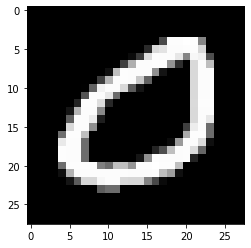

In [25]:
show_test(np.random.randint(10000))